In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
import matplotlib.pyplot as plt
from pylib.utils.functions_for_classification import mixtured_2d_2cls, plot_scatter

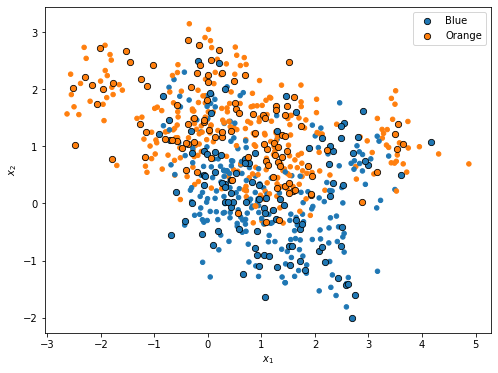

In [3]:
X_train, X_test, y_train, y_test = mixtured_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## 装袋法

In [44]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.tree import DecisionTreeClassifier 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss, accuracy_score
import numpy as np

In [89]:
class BaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=DecisionTreeClassifier(max_depth=3), 
                 n_estimators=10, max_samples=1.0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
    
    def __bootstrap(self, X, y, max_samples):
        subset_idx = np.random.choice(len(X), size=max_samples, replace=True)
        return X[subset_idx], y[subset_idx]
    
    def fit(self, X, y):
        if isinstance(self.max_samples, float):
            max_samples = int(self.max_samples * len(X))
        self.estimators = []
        self.loss_history = []
        y_pred = np.zeros(max_samples)
        for i in range(self.n_estimators):
            estimator = self.estimator
            X_subset, y_subset = self.__bootstrap(X, y, max_samples)
            estimator.fit(X_subset, y_subset)
            if hasattr(self.estimator, 'predict_proba'):
                y_pred += estimator.predict_proba(X_subset)[:, 1]
                y_pred = y_pred / (i + 1)
            else:
                y_pred += estimator.predict(X_subset)
                y_pred = np.round(y_pred / (i + 1))
            loss = accuracy_score(y_subset, np.where(y_pred >=0.5, 1, 0))
            self.loss_history.append(loss)
            self.estimators.append(estimator)
        
        return self
    
    def predict(self, X):
        y_pred = np.zeros(len(X))
        if hasattr(self.estimator, 'predict_proba'):
            for estimator in self.estimators:
                y_pred += estimator.predict_proba(X)[:, 1]       
            y_pred = y_pred / self.n_estimators
        else:
            for estimator in self.estimators:
                y_pred += estimator.predict(X)
            y_pred = np.round(y_pred / self.n_estimators)
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        
        return y_pred
            

In [113]:
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), 
                  n_estimators=150, max_samples=0.8)
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight=None,
                                                   criterion='gini',
                                                   max_depth=5,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                  max_samples=0.8, n_estimators=150)

In [114]:
train_err = 1 - bagging.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.140


In [115]:
test_err = 1 - bagging.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.234


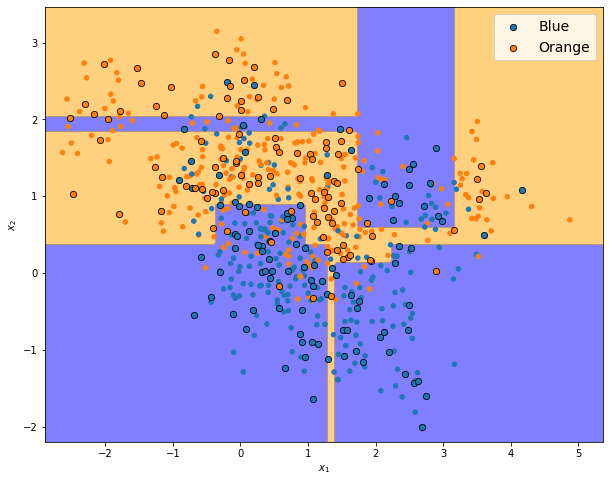

In [118]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, bagging)
plt.show()

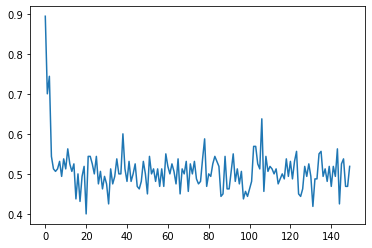

In [117]:
loss_history = bagging.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()